# Task 2 NER 

#### Group: B (Joseph Weibel / Rebecka Fahrni)

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from langdetect import detect
import seaborn as sns

data = load_dataset('argilla/medical-domain')['train']
df = data.to_pandas()

df['label'] = df.prediction.apply(lambda x: x[0]['label'])

For this task, we only work with English texts.

In [4]:
df['language'] = df['text'].apply(lambda x: detect(x))
unique_languages = df['language'].unique()

print('Number of non-english texts:', sum(df['language'] != 'en'))
english_texts = df[df['language'] == 'en']
df['text'].head()

Number of non-english texts: 13


0    PREOPERATIVE DIAGNOSIS:,  Iron deficiency anem...
1    CLINICAL INDICATION:  ,Normal stress test.,PRO...
2    FINDINGS:,Axial scans were performed from L1 t...
3    PREOPERATIVE DIAGNOSIS: , Blood loss anemia.,P...
4    REASON FOR VISIT:  ,Elevated PSA with nocturia...
Name: text, dtype: object

## Investigating standard and potential new NER types are most prominent in your data set (i.e., manual data inspection)

As evident from the following example, the texts describe treatments of patients. Frequently mentioned are body parts, diseases, treatment methods, and medications. Additionally, the texts contain numerous numerical values that describe medication doses, represent measurements, or enumerate points. For a Named Entity Recognition (NER) task, it would be beneficial to extract these numbers to generate precise answers to related questions. On the other hand, diseases and treatments are valuable for classifying according to specialty. These two entities should provide a clear indication of the respective medical field.

In [5]:
print(english_texts['text'].sample(1, random_state=13).values[0])

FINAL DIAGNOSES:,  Delivered pregnancy, cholestasis of pregnancy, fetal intolerance to labor, failure to progress.,PROCEDURE: , Included primary low transverse cesarean section.,SUMMARY: , This 32-year-old gravida 2 was induced for cholestasis of pregnancy at 38-1/2 weeks.  The patient underwent a 2-day induction.  On the second day, the patient continued to progress all the way to the point of 9.5 cm at which point, she failed to progress.  During the hour or two of evaluation at 9.5 cm, the patient was also noted to have some fetal tachycardia and an occasional late deceleration.  Secondary to these factors, the patient was brought to the operative suite for primary low transverse cesarean section, which she underwent without significant complication.  There was a slightly enlarged blood loss at approximately 1200 mL, and postoperatively, the patient was noted to have a very mild tachycardia coupled with 100.3 degrees Fahrenheit temperature right at delivery.  It was felt that this w

## Applying spaCy's standard NER classifier

We apply spaCy's standard NLP pipeline `en_core_web_sm` to the samples. When counting the number of found entities per label, we can see that many numbers (cardinal, quantity, percent, money, ordinal) were found. Also, only a few events, locations, languages and laws were detected as these type of words are very uncommon in such type of texts. Surprisingly, many organisations were identified, making them the second most common category.

In [9]:
import spacy

nlp = spacy.load("en_core_web_sm", enable=['ner'])

def get_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df_sample = df #.sample(100)
df_sample['entities'] = df_sample['text'].apply(get_entities)

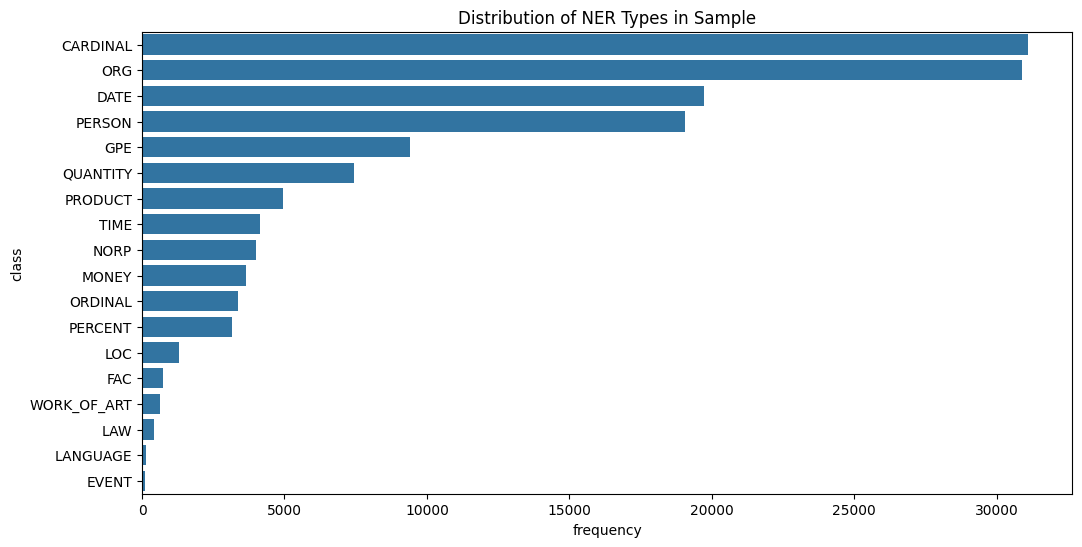

In [10]:
all_entities = [ent[1] for sublist in df_sample['entities'].tolist() for ent in sublist]
entity_df = pd.DataFrame(all_entities, columns=['entity'])

plt.figure(figsize=(12, 6))
sns.countplot(y='entity', data=entity_df, order=entity_df['entity'].value_counts().index)
plt.title('Distribution of NER Types in Sample')
plt.xlabel('frequency')
plt.ylabel('class')
plt.show()

When looking at an individual sample, it is evident that many tokens were misclassified, especially organisations, persons and locations (GPE). Drugs are often classified as either of those classes. The classification of dates and numbers is more correct. However, some numbers (eg. *Temperature 98.7*) and dates (eg. *07/2007*) were missed by the model, even these are values which should be easier to identify for the model. 

In [11]:
from spacy import displacy

text = df_sample['text'].iloc[822]
doc = nlp(text)

displacy.render(doc, style='ent')

## Evaluating the quality of NER classification and evaluate it automatically and manually with 100 randomly sampled entities

For the evaluation, we propose to label the entities of 10 randomly sampled texts. Because of the large text, this should result in more than 100 labeled entities. Then, we compare the predictions for these texts with our labels by looking at each sample and calculating metrics over all ten samples. 

The following code samples these texts and stores them in a text file to be used for annotation.

In [12]:
df_sample['text'].sample(10, random_state=12).to_csv('ner.txt', index=False, header=None, quoting=None)

The standard spacy NER model recognizes the following entities:

In [13]:
print('CARDINAL:', spacy.explain('CARDINAL'))
print('DATE:', spacy.explain('DATE'))
print('EVENT:', spacy.explain('EVENT'))
print('FAC:', spacy.explain('FAC'))
print('GPE:', spacy.explain('GPE'))
print('LANGUAGE:', spacy.explain('LANGUAGE'))
print('LAW:', spacy.explain('LAW'))
print('LOC:', spacy.explain('LOC'))
print('MONEY:', spacy.explain('MONEY'))
print('NORP:', spacy.explain('NORP'))
print('ORDINAL:', spacy.explain('ORDINAL'))
print('ORG:', spacy.explain('ORG'))
print('QUANTITY:', spacy.explain('QUANTITY'))
print('PERCENT:', spacy.explain('PERCENT'))
print('PERSON:', spacy.explain('PERSON'))
print('PRODUCT:', spacy.explain('PRODUCT'))
print('TIME:', spacy.explain('TIME'))
print('WORK_OF_ART:', spacy.explain('WORK_OF_ART'))

CARDINAL: Numerals that do not fall under another type
DATE: Absolute or relative dates or periods
EVENT: Named hurricanes, battles, wars, sports events, etc.
FAC: Buildings, airports, highways, bridges, etc.
GPE: Countries, cities, states
LANGUAGE: Any named language
LAW: Named documents made into laws.
LOC: Non-GPE locations, mountain ranges, bodies of water
MONEY: Monetary values, including unit
NORP: Nationalities or religious or political groups
ORDINAL: "first", "second", etc.
ORG: Companies, agencies, institutions, etc.
QUANTITY: Measurements, as of weight or distance
PERCENT: Percentage, including "%"
PERSON: People, including fictional
PRODUCT: Objects, vehicles, foods, etc. (not services)
TIME: Times smaller than a day
WORK_OF_ART: Titles of books, songs, etc.


In [14]:
import json
with open('ner_annotations.json', 'r') as file:
	test_data = json.load(file)

The identified entities in the ground truth matches with the manual observation of the texts. The most common classes are numeric values such as cardinal, quantity, date, ordinal and percent. Of the total 18 classes in the spacy model, only 10 were found in the text samples.

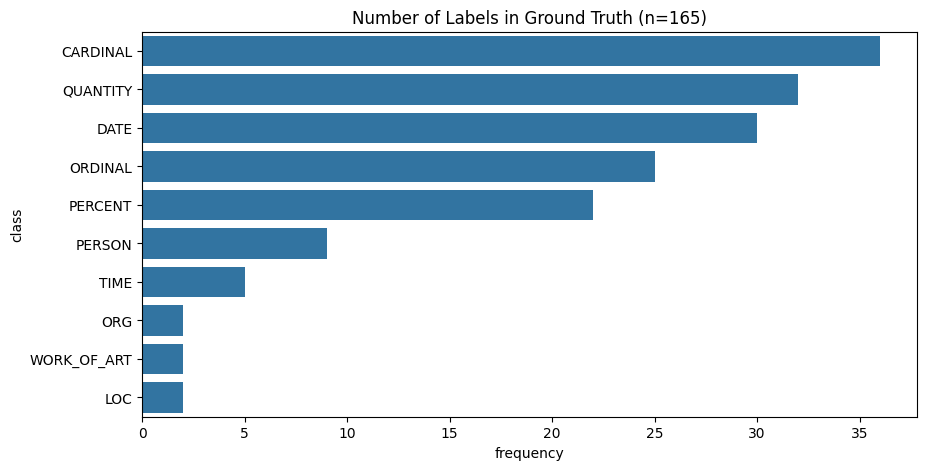

In [15]:
stats = {}
for text, annotations in test_data['annotations']:
	for start, end, label in annotations['entities']:
		stats[label] = stats[label] if label in stats else 0
		stats[label] += 1

chart_stats = pd.DataFrame.from_dict(stats, orient='index', columns=['n'])
chart_stats = chart_stats.reset_index(names='label')
chart_stats = chart_stats.sort_values('n', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(chart_stats, x='n', y='label')
plt.title(f'Number of Labels in Ground Truth (n={chart_stats["n"].sum()})')
plt.xlabel('frequency')
plt.ylabel('class')
plt.show()

We can now compare the annotations by the model with the ones from the ground truth. First, the model detected many more entities than there are apparent in the ground truth. Entities like organisations and products were often missidentified. Also, the model has problems identifying simple patterns like dates. Numerical are recogniozed well, but in some cases, the wrong class was attached to the labels. Quantities and dates get classified as cardinals.

In [16]:
from IPython.display import display, Markdown

i = 9
text, _ = test_data['annotations'][i]
doc = nlp(text)

display(Markdown('#### Prediction'))
displacy.render(doc, style='ent')

#### Prediction

In [17]:
text, annotations = test_data['annotations'][i]
doc = nlp(text)
spans = [doc.char_span(start, end, label, alignment_mode='expand') for start, end, label in annotations['entities']]
spans = spacy.util.filter_spans(spans)
doc.ents = spans

display(Markdown('#### Ground Truth'))
displacy.render(doc, style='ent')

#### Ground Truth

Next, we want to evaluate the recognized entities using quantitative strategies. For that, precision and recall are calculated for each entity class. All detected ordinals and percentages were also identified as such in the ground truth. And all percentages in the ground truth got successfully detected by the model, resulting in a recall of 1. Percentages seem to be easy detectable tokens as they always have the `%` suffix. Recall of ordinals is very low with around 0.2. Also, no correct entities for classes *person*, *work_of_art* and *loc* were found at all. The fact that the model detects organisations, which are not real organisations, is reflected by the low precision score. 

In [18]:
from spacy.scorer import Scorer, Example

scorer = Scorer()
examples = []
for text, annotations in test_data['annotations']:
	doc = nlp.make_doc(text)
	spans = [doc.char_span(start, end, label, alignment_mode='expand') for start, end, label in annotations['entities']]
	spans = spacy.util.filter_spans(spans)
	example = Example.from_dict(doc, {'entities': spans})
	example.predicted = nlp(str(example.predicted))

	examples.append(example)

scores = scorer.score(examples)


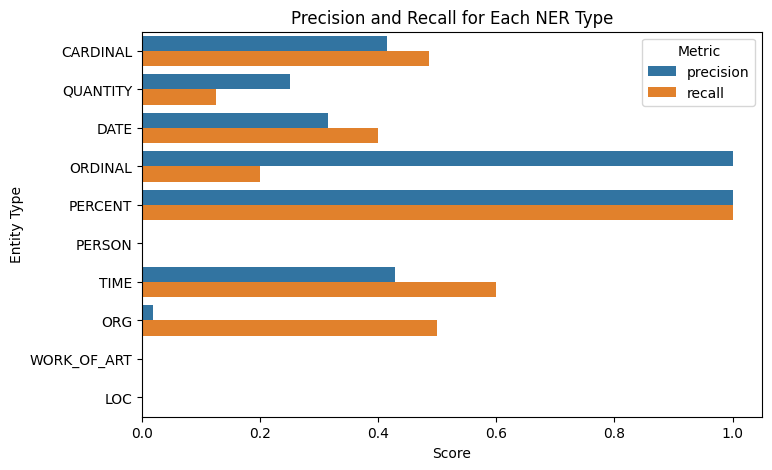

In [33]:
chart_scores = pd.DataFrame(scores['ents_per_type']).T[['p', 'r']].rename(columns={'p': 'precision', 'r': 'recall'}).reset_index(names='label').melt(['label'], var_name='metric', value_name='score')

plt.figure(figsize=(8, 5))
sns.barplot(chart_scores, x='score', y='label', hue='metric', order=chart_stats['label'])
plt.title('Precision and Recall for Each NER Type')
plt.xlabel('Score')
plt.ylabel('Entity Type')
plt.legend(title='Metric')
plt.show()


Finally, we calculate precision and recall along with the F-score for all entities. The results are quite underwhelming with an F-score of about 0.30. However, as the ground truth consists of only 165 entities, it is not representative for the whole dataset, especially since the texts are rather diverse. Also, entities can be ambiguous and the manually annotated entities could look different, when annotated by another person. Manual inspection of the predictions is more time-consuming, but will deliver more insights than just a few metrics and difficult tokens can be identified more easily. 

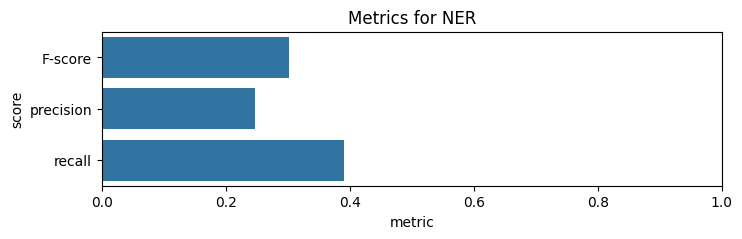

In [20]:
chart_scores = pd.DataFrame([
	{'metric': 'F-score', 'score': scores['ents_f']},
	{'metric': 'precision', 'score': scores['ents_p']},
	{'metric': 'recall', 'score': scores['ents_r']}
])

plt.figure(figsize=(8, 2))
sns.barplot(chart_scores, x='score', y='metric')
plt.title('Metrics for NER')
plt.xlabel('metric')
plt.ylabel('score')
plt.xlim(0, 1)
plt.show()

In [21]:
chart_scores

,metric,score
0,F-score,0.301887
1,precision,0.246154
2,recall,0.390244


## Extending standard NER types with the NER Annotator 'prodigy' and re-run the NER classification as well as its evaluation

In the next step, an additional class for the NER task should be added, indicating the name of drugs mentioned in the texts. This type seems sensible for the classification task as drugs are applied for specific diseases which belong to certain fields of medicine. For that, we annotate the texts in the test dataset again, but this time with the new class, and additional 25 randomly selected samples which are used for training. 

In [23]:
import json
with open('drug_annotations_train.json', 'r') as file:
	drug_train_data = json.load(file)

with open('drug_annotations_test.json', 'r') as file:
	drug_test_data = json.load(file)

Drugs were mentioned 110 times in the training dataset. Looking at the histogram with number of occurences per text, we can see that most samples contain less than 9 drug entities while there are two outliers with 12 and 16 entities. Three texts mention no drugs at all.

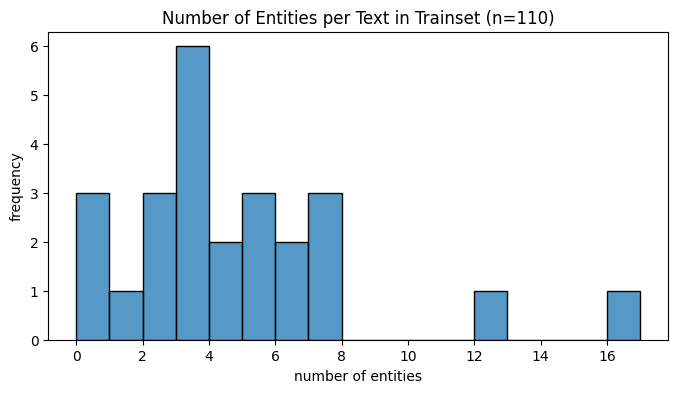

In [24]:
n_annotations = [len(annotations['entities']) for _, annotations in drug_train_data['annotations']]

plt.figure(figsize=(8, 4))
sns.histplot(n_annotations, binwidth=1)
plt.title(f'Number of Entities per Text in Trainset (n={sum(n_annotations)})')
plt.xlabel('number of entities')
plt.ylabel('frequency')
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
plt.show()

Now, we can use the existing NER pipeline and add the additional *drug* label. Using the manually labeled training data, the model can be finetuned. The training process is run for 50 epochs, until the loss does not improve anymore substantially. Because of stochastic gradient descent, there are some spikes in the loss curve.

In [25]:
n_epochs = 50

new_nlp = spacy.load("en_core_web_sm", enable=['ner'])
pipeline = nlp.get_pipe('ner')
pipeline.add_label('DRUG')

losses = []
optimizer = new_nlp.resume_training()
for i in range(n_epochs):
	np.random.shuffle(drug_train_data['annotations'])
	for text, annotations in drug_train_data['annotations']:
		doc = new_nlp.make_doc(text)
		example = Example.from_dict(doc, annotations)

		it_losses = {}
		new_nlp.update([example], sgd=optimizer, losses=it_losses)
		losses.append({'epoch': i, 'loss': it_losses['ner']})

losses = pd.DataFrame(losses)

C:\Users\ahnki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "CC:, Progressive unsteadiness following head traum..." with entities "[[316, 326, 'DRUG'], [742, 751, 'DRUG'], [753, 766...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\ahnki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "SUBJECTIVE:,  The patient complains of backache, s..." with entities "[[789, 796, 'DRUG'], [2091, 2099, 'DRUG'], [2233, ...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment

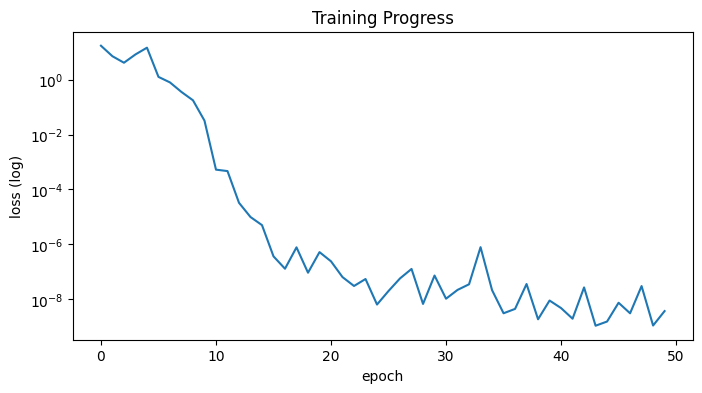

In [26]:
epoch_losses = losses.groupby('epoch')['loss'].mean()

plt.figure(figsize=(8, 4))
sns.lineplot(x=epoch_losses.index, y=epoch_losses.values)
plt.title('Training Progress')
plt.xlabel('epoch')
plt.ylabel('loss (log)')
plt.yscale('log')
plt.show()

Having finetuned the NER model, the model can now be evaluated using the manually labeled test dataset. This dataset consists of 50 drug labels in 10 texts.

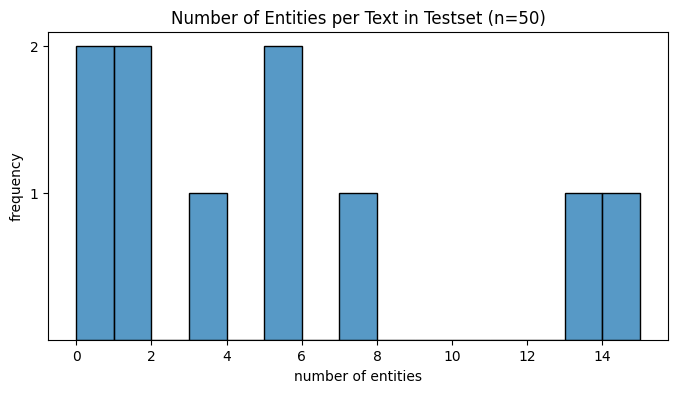

In [284]:
n_annotations = [len(annotations['entities']) for _, annotations in drug_test_data['annotations']]

plt.figure(figsize=(8, 4))
sns.histplot(n_annotations, binwidth=1)
plt.title(f'Number of Entities per Text in Testset (n={sum(n_annotations)})')
plt.xlabel('number of entities')
plt.ylabel('frequency')
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14])
plt.yticks([1, 2])
plt.show()

We apply the same procedure as used for the standard spacy pipeline and start with manually comparing the prediction with the ground truth. It is apparent that the model has forgotten how to label the standard spacy classes such as *quantity* and *percent*. This can be attributed to the training data which only consist of *drug* entities. The weights of the model were adapted according to only them and the information how to identify the other classes got lost. This phenomenon is called "catastrophic forgetting". However, the model identifies the medication well, even some drugs remain undetected. In some texts, the model predicts drug entities which do not exist in the ground truth.

In [316]:
i = 0
text, _ = drug_test_data['annotations'][i]
doc = new_nlp(text)

display(Markdown('#### Prediction'))
displacy.render(doc, style='ent')

#### Prediction

In [317]:
text, annotations = drug_test_data['annotations'][i]
doc = new_nlp(text)
spans = [doc.char_span(start, end, label, alignment_mode='expand') for start, end, label in annotations['entities']]
spans = spacy.util.filter_spans(spans)
doc.ents = spans

display(Markdown('#### Ground Truth'))
displacy.render(doc, style='ent')

#### Ground Truth

Both cases, undetected or wrongly detected entities, can be described using precision, recall and their combination f-score. Precision is higher than recall, meaning that the model misses more drugs than it wrongly classifies as a drug. The quality of the model is not sufficient and more training data is needed to improve the accuracy of the entity recognition.

In [287]:
scorer = Scorer()
examples = []
for text, annotations in drug_test_data['annotations']:
	doc = new_nlp.make_doc(text)
	spans = [doc.char_span(start, end, label, alignment_mode='expand') for start, end, label in annotations['entities']]
	spans = spacy.util.filter_spans(spans)
	example = Example.from_dict(doc, {'entities': spans})
	example.predicted = new_nlp(str(example.predicted))

	examples.append(example)

scores = scorer.score(examples)

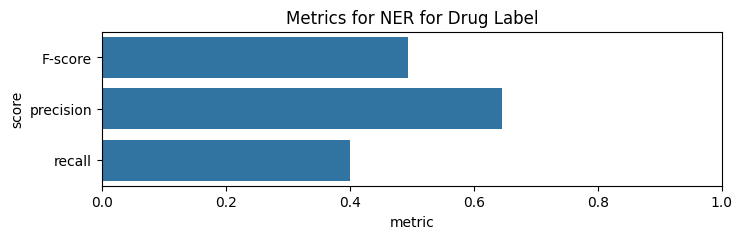

In [288]:
chart_scores = pd.DataFrame([
	{'metric': 'F-score', 'score': scores['ents_f']},
	{'metric': 'precision', 'score': scores['ents_p']},
	{'metric': 'recall', 'score': scores['ents_r']}
])

plt.figure(figsize=(8, 2))
sns.barplot(chart_scores, x='score', y='metric')
plt.title('Metrics for NER for Drug Label')
plt.xlabel('metric')
plt.ylabel('score')
plt.xlim(0, 1)
plt.show()

In [318]:
chart_scores

,metric,score
0,F-score,0.493827
1,precision,0.645161
2,recall,0.400000


## How NER type information could help in other NLP use cases

In general, the extracted entities from NER can be used for **information extraction**. This plays an important role in **question answering** tasks, which goal is to find the relevant entities in the question and extracting the matching answers in texts. Recognized entities can be used to verify texts generated in **text summarization** tasks, to check if all important facts have been transferred to the summarization. Also, **sentiment analysis** can also applied to individual tokens, extracted using NER, instead of whole sentences and texts. Finally, for our **text classification** task, the identified entities can be used as input features, when they indicate the output class. 

## Additional sections (Stuff)

In [14]:
import json

results = []
for text in df_sample['text'].sample(10, random_state=12):
	doc = nlp(text)
	entities = []
	for ent in doc.ents:
		entities.append([ent.start, ent.end, ent.label_])

	results.append(
		[text, {'entities': entities}]
	)

with open('ner.json', 'w') as file:
	json.dump(results, file)

In [205]:
with open('ner.txt', 'w') as file:
	file.write("\n".join([text for text, _ in test_data['annotations']]))

In [277]:
df_sample['text'].sample(5, random_state=16).to_csv('ner_train_2.txt', index=False, header=None, quoting=None)